In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
plt.rcParams.update({'font.size': 16})

In [ ]:
df = pd.read_csv('/content/assignment4.csv')

In [ ]:
df.shape

(30, 9)

In [ ]:
df.head()

,Date,BSE500,GOITenYR,DHANBANK,VIDHIING,IMFA,GPPL,CENTURYPLY,TANLA
0,01-04-2018,15047.73,0.0777,21.299999,96.571831,447.905792,126.112366,317.554962,36.385201
1,01-05-2018,14765.69,0.0783,20.350000,76.355728,324.265503,98.177170,272.155212,29.663439
2,01-06-2018,14528.54,0.0790,18.400000,70.829048,283.489319,89.715820,245.022476,30.101814
3,01-07-2018,15314.81,0.0777,17.850000,80.137161,306.674835,98.602364,243.950806,39.064167
4,01-08-2018,15846.20,0.0795,15.450000,84.306412,322.765106,94.477982,217.597504,39.112881


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        30 non-null     object 
 1   BSE500      30 non-null     float64
 2   GOITenYR    30 non-null     float64
 3   DHANBANK    30 non-null     float64
 4   VIDHIING    30 non-null     float64
 5   IMFA        30 non-null     float64
 6   GPPL        30 non-null     float64
 7   CENTURYPLY  30 non-null     float64
 8   TANLA       30 non-null     float64
dtypes: float64(8), object(1)
memory usage: 2.2+ KB


In [ ]:
df.isnull().sum()

Date          0
BSE500        0
GOITenYR      0
DHANBANK      0
VIDHIING      0
IMFA          0
GPPL          0
CENTURYPLY    0
TANLA         0
dtype: int64

In [ ]:
df['r(m,t)'] = np.log(df['BSE500']/df['BSE500'].shift(1))

In [ ]:
df.describe()

,BSE500,GOITenYR,DHANBANK,VIDHIING,IMFA,GPPL,CENTURYPLY,TANLA,"r(m,t)"
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,29.000000
mean,14557.237667,0.069390,15.096667,71.675325,222.966536,80.943351,171.311555,65.668714,-0.000454
std,1043.151833,0.007275,3.053176,14.134709,68.281152,13.874456,47.872430,56.832550,0.071257
min,11098.230000,0.058400,8.050000,45.454704,111.150002,55.125748,101.699997,29.663439,-0.276126
25%,14294.862500,0.063700,13.650000,63.944935,180.362499,72.618881,150.189583,36.587477,-0.017713
50%,14696.655000,0.067900,15.100000,70.339466,217.044312,80.543946,163.840676,48.981420,-0.000707
75%,15301.865000,0.076050,16.649999,76.130690,251.269603,87.819992,173.580150,69.880066,0.038227
max,15846.200000,0.080200,21.299999,122.458694,447.905792,126.112366,317.554962,290.081360,0.136469


In [ ]:
df['x(t)'] = df['r(m,t)'] - df['GOITenYR']

In [ ]:
def create_df(old_df,column):
	new_df = df[['Date','BSE500','GOITenYR',column,'r(m,t)','x(t)']]
	new_df['r(i,t)'] = np.log(new_df[column]/new_df[column].shift(1))
	new_df = new_df.dropna()
	new_df['y(t)'] = new_df['r(i,t)'] - new_df['GOITenYR']
	return new_df

In [ ]:
def returns_plot(df,company_name):
  fig, ([ax1,ax2]) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
  fig.suptitle(company_name+' & BSE 500\n(Stock returns vs market returns)', fontsize=15)
  # # Move left y-axis and bottim x-axis to centre, passing through (0,0)
  # ax1.spines['left'].set_position('center')
  # ax1.spines['bottom'].set_position('center')

  # # Eliminate upper and right axes
  # ax1.spines['right'].set_color('none')
  # ax1.spines['top'].set_color('none')

  # # Show ticks in the left and lower axes only
  # ax1.xaxis.set_ticks_position('bottom')
  # ax1.yaxis.set_ticks_position('left')
  ax1.scatter('r(m,t)','r(i,t)',data = df)
  ax1.set_ylabel(company_name+'(Stock returns)')
  ax1.set_xlabel('Market returns')
  ax2.plot('r(i,t)',data=df, marker='o')
  ax2.plot('r(m,t)',data=df, marker='o')
  ax2.legend(['Stock returns','Market returns'])


In [ ]:
def ols_model(df):
  # split dependent and independent variable
  X = df['x(t)']
  y = df['y(t)']
  # Add a constant to the independent value
  X1 = sm.add_constant(X)
  # make regression model 
  model = sm.OLS(y, X1)
  results = model.fit()
  return results

In [ ]:
def characteristic_line(df,ylabel):
  fig,ax = plt.subplots(figsize=(10,7))
  ax = sns.regplot(x="x(t)", y="y(t)", data=df)
  ax.set_ylabel(ylabel)
  ax.set_xlabel('S&P BSE 500')
  ax.set_title('Characteristic line')

In [ ]:
def diagnostic_plots(results):
  residuals = results.resid
  fitted = results.fittedvalues
  lowess = sm.nonparametric.lowess
  smoothed = lowess(residuals,fitted)
  fig, ([ax1,ax2]) = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 14))
  ax1.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
  ax1.plot(smoothed[:,0],smoothed[:,1])
  ax1.set_ylabel('Residuals')
  ax1.set_xlabel('Fitted Values')
  ax1.set_title('Residuals vs. Fitted')
  ax1.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)
  
  sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
  sorted_student_residuals.index = results.resid.index
  sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
  theoretical_quantiles = stats.probplot(sorted_student_residuals, dist = 'norm', fit = False)[0]

  x = theoretical_quantiles
  y = sorted_student_residuals
  ax2.scatter(x,y, edgecolor = 'k',facecolor = 'none')
  ax2.set_title('Normal Q-Q')
  ax2.set_ylabel('Standardized Residuals')
  ax2.set_xlabel('Theoretical Quantiles')
  ax2.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], ls = '--')

#Dhanlaxmi Bank Ltd

In [ ]:
DhanBank = create_df(df,'DHANBANK')

In [ ]:
DhanBank.head()

,Date,BSE500,GOITenYR,DHANBANK,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,20.35,-0.018921,-0.097221,-0.045626,-0.123926
2,01-06-2018,14528.54,0.0790,18.40,-0.016191,-0.095191,-0.100730,-0.179730
3,01-07-2018,15314.81,0.0777,17.85,0.052705,-0.024995,-0.030347,-0.108047
4,01-08-2018,15846.20,0.0795,15.45,0.034109,-0.045391,-0.144395,-0.223895
5,01-09-2018,14445.89,0.0802,11.15,-0.092520,-0.172720,-0.326170,-0.406370


In [ ]:
DhanBank.describe()

,BSE500,GOITenYR,DHANBANK,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,14.882759,-0.000454,-0.069557,-0.018935,-0.088038
std,1057.421527,0.007230,2.869335,0.071257,0.071859,0.170812,0.171232
min,11098.230000,0.058400,8.050000,-0.276126,-0.337526,-0.498325,-0.559725
25%,14285.110000,0.063700,13.550000,-0.017713,-0.092513,-0.124053,-0.187753
50%,14627.620000,0.067000,15.000000,-0.000707,-0.066010,-0.029093,-0.094693
75%,15304.570000,0.075900,16.200001,0.038227,-0.028173,0.061369,-0.012331
max,15846.200000,0.080200,20.350000,0.136469,0.075369,0.380018,0.321118


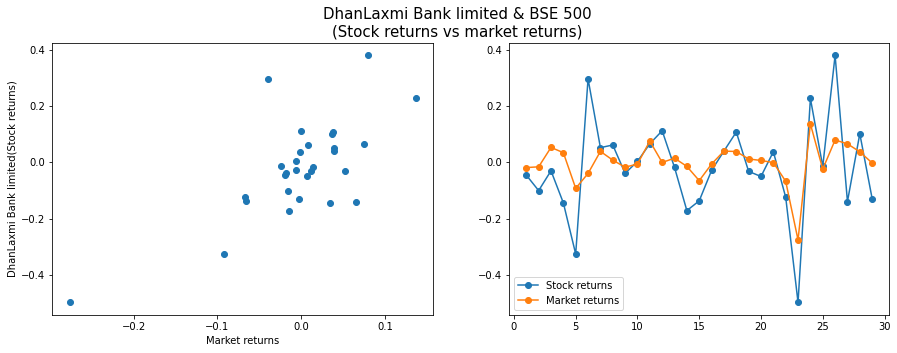

In [ ]:
returns_plot(DhanBank,'DhanLaxmi Bank limited')

In [ ]:
results = ols_model(DhanBank)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     27.18
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.72e-05
Time:                        17:08:00   Log-Likelihood:                 20.636
No. Observations:                  29   AIC:                            -37.27
Df Residuals:                      27   BIC:                            -34.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0294      0.032      0.915      0.3

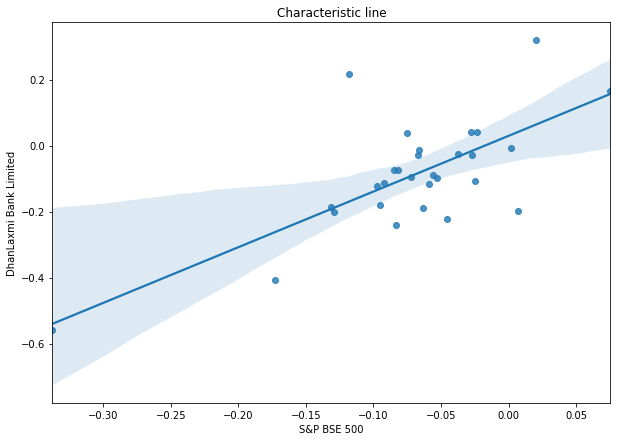

In [ ]:
characteristic_line(DhanBank,'DhanLaxmi Bank Limited')

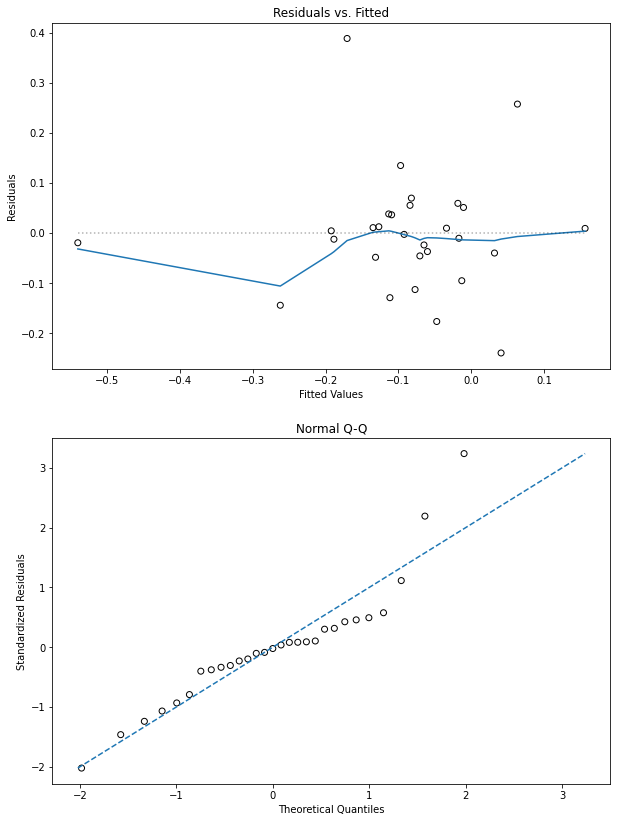

In [ ]:
diagnostic_plots(results)

#Vidhi Specialty Food Ingredients Ltd

In [ ]:
VIDHI = create_df(df,'VIDHIING')

In [ ]:
VIDHI.head()

,Date,BSE500,GOITenYR,VIDHIING,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,76.355728,-0.018921,-0.097221,-0.234884,-0.313184
2,01-06-2018,14528.54,0.0790,70.829048,-0.016191,-0.095191,-0.075134,-0.154134
3,01-07-2018,15314.81,0.0777,80.137161,0.052705,-0.024995,0.123470,0.045770
4,01-08-2018,15846.20,0.0795,84.306412,0.034109,-0.045391,0.050718,-0.028782
5,01-09-2018,14445.89,0.0802,71.867249,-0.092520,-0.172720,-0.159637,-0.239837


In [ ]:
VIDHI.describe()

,BSE500,GOITenYR,VIDHIING,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,70.816824,-0.000454,-0.069557,0.008189,-0.060914
std,1057.421527,0.007230,13.565582,0.071257,0.071859,0.154362,0.156409
min,11098.230000,0.058400,45.454704,-0.276126,-0.337526,-0.347211,-0.408611
25%,14285.110000,0.063700,63.818703,-0.017713,-0.092513,-0.075134,-0.154134
50%,14627.620000,0.067000,69.849884,-0.000707,-0.066010,0.024865,-0.049938
75%,15304.570000,0.075900,75.455574,0.038227,-0.028173,0.074108,0.008508
max,15846.200000,0.080200,122.458694,0.136469,0.075369,0.360042,0.299642


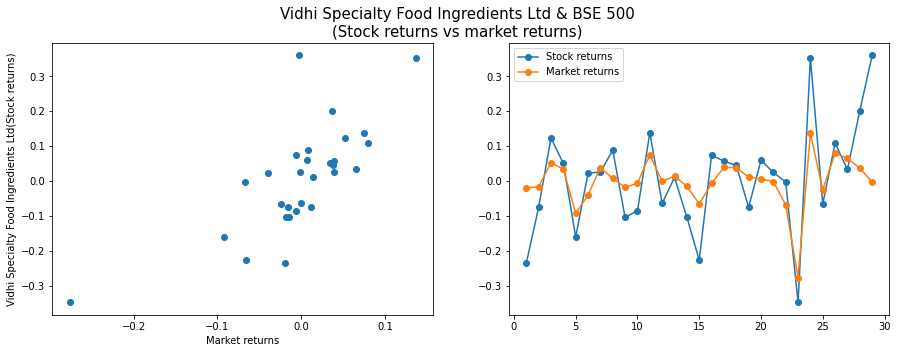

In [ ]:
returns_plot(VIDHI,'Vidhi Specialty Food Ingredients Ltd')

In [ ]:
results = ols_model(VIDHI)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     34.07
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           3.26e-06
Time:                        17:08:02   Log-Likelihood:                 24.997
No. Observations:                  29   AIC:                            -45.99
Df Residuals:                      27   BIC:                            -43.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0522      0.028      1.890      0.0

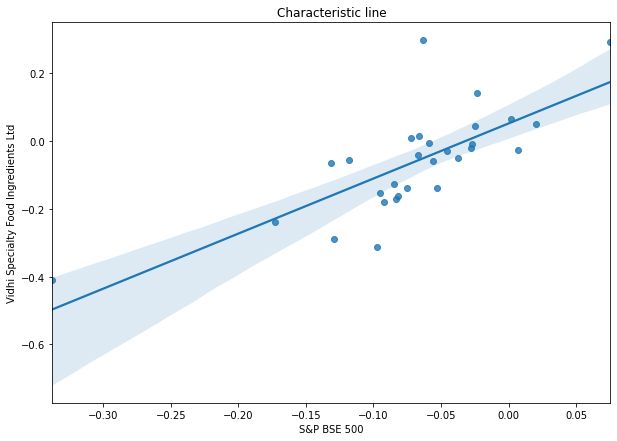

In [ ]:
characteristic_line(VIDHI,'Vidhi Specialty Food Ingredients Ltd')

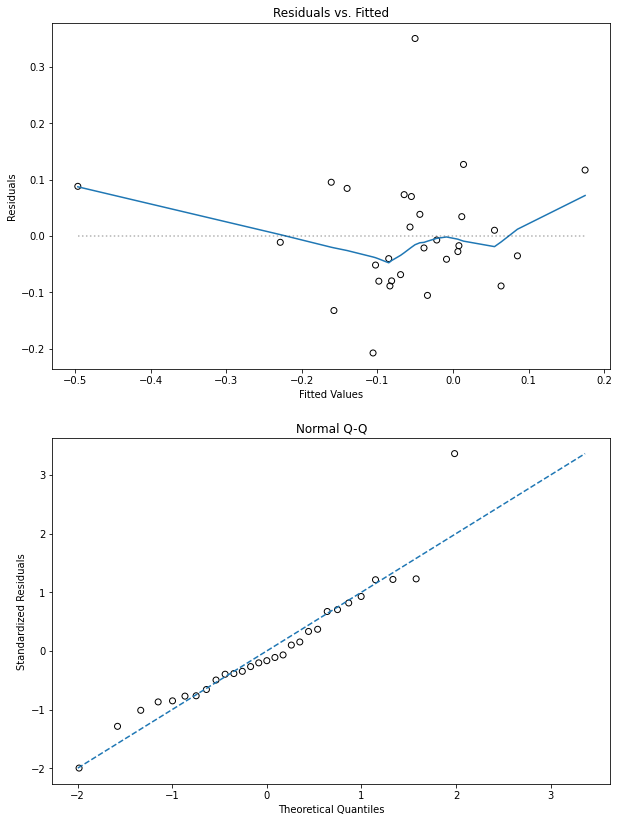

In [ ]:
diagnostic_plots(results)

#Indian Metals & Ferro Alloys Ltd.

In [ ]:
imfa = create_df(df,'IMFA')

In [ ]:
imfa.head()

,Date,BSE500,GOITenYR,IMFA,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,324.265503,-0.018921,-0.097221,-0.323020,-0.401320
2,01-06-2018,14528.54,0.0790,283.489319,-0.016191,-0.095191,-0.134388,-0.213388
3,01-07-2018,15314.81,0.0777,306.674835,0.052705,-0.024995,0.078614,0.000914
4,01-08-2018,15846.20,0.0795,322.765106,0.034109,-0.045391,0.051137,-0.028363
5,01-09-2018,14445.89,0.0802,260.501892,-0.092520,-0.172720,-0.214315,-0.294515


In [ ]:
imfa.describe()

,BSE500,GOITenYR,IMFA,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,215.210010,-0.000454,-0.069557,-0.023375,-0.092478
std,1057.421527,0.007230,54.400873,0.071257,0.071859,0.174204,0.175884
min,11098.230000,0.058400,111.150002,-0.276126,-0.337526,-0.617481,-0.678881
25%,14285.110000,0.063700,179.449997,-0.017713,-0.092513,-0.083382,-0.157482
50%,14627.620000,0.067000,215.485291,-0.000707,-0.066010,0.013013,-0.060687
75%,15304.570000,0.075900,248.711838,0.038227,-0.028173,0.073411,0.000914
max,15846.200000,0.080200,324.265503,0.136469,0.075369,0.309023,0.248223


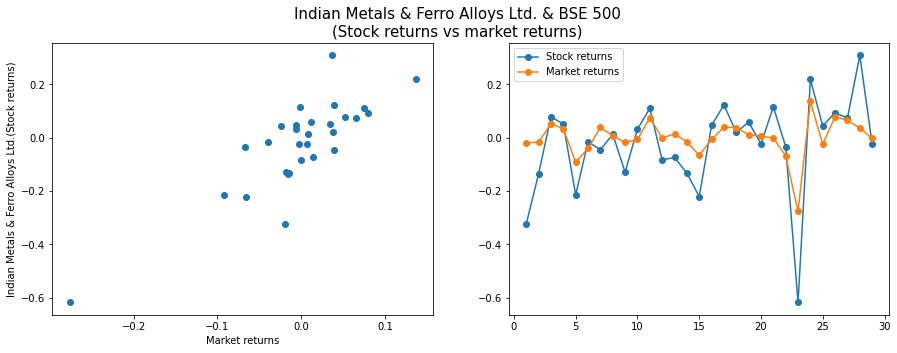

In [ ]:
returns_plot(imfa,'Indian Metals & Ferro Alloys Ltd.')

In [ ]:
results = ols_model(imfa)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     67.18
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           8.41e-09
Time:                        17:08:03   Log-Likelihood:                 27.875
No. Observations:                  29   AIC:                            -51.75
Df Residuals:                      27   BIC:                            -49.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.025      2.053      0.0

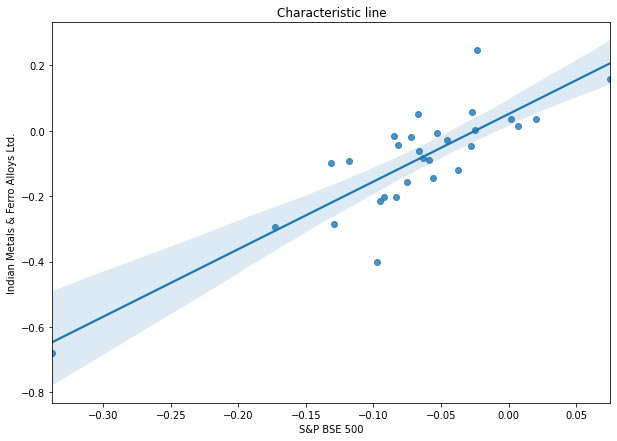

In [ ]:
characteristic_line(imfa,'Indian Metals & Ferro Alloys Ltd.')

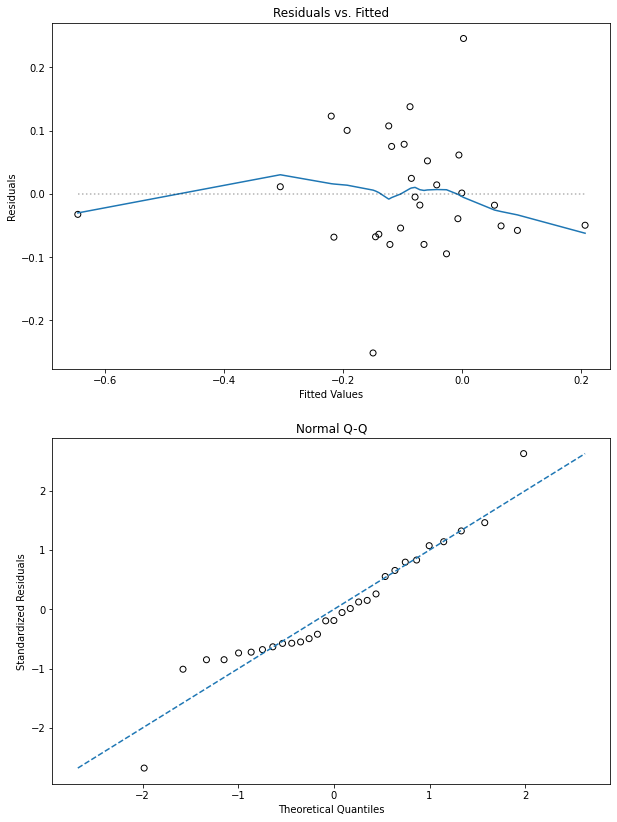

In [ ]:
diagnostic_plots(results)

#Gujarat Pipavav Port Ltd

In [ ]:
gppl = create_df(df,'GPPL')

In [ ]:
gppl.head()

,Date,BSE500,GOITenYR,GPPL,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,98.177170,-0.018921,-0.097221,-0.250400,-0.328700
2,01-06-2018,14528.54,0.0790,89.715820,-0.016191,-0.095191,-0.090127,-0.169127
3,01-07-2018,15314.81,0.0777,98.602364,0.052705,-0.024995,0.094448,0.016748
4,01-08-2018,15846.20,0.0795,94.477982,0.034109,-0.045391,-0.042728,-0.122228
5,01-09-2018,14445.89,0.0802,87.885712,-0.092520,-0.172720,-0.072330,-0.152530


In [ ]:
gppl.describe()

,BSE500,GOITenYR,GPPL,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,79.385799,-0.000454,-0.069557,-0.014738,-0.083842
std,1057.421527,0.007230,11.135405,0.071257,0.071859,0.111790,0.113808
min,11098.230000,0.058400,55.125748,-0.276126,-0.337526,-0.250400,-0.328700
25%,14285.110000,0.063700,72.465996,-0.017713,-0.092513,-0.072330,-0.152530
50%,14627.620000,0.067000,80.357285,-0.000707,-0.066010,-0.011936,-0.080266
75%,15304.570000,0.075900,87.622833,0.038227,-0.028173,0.050000,-0.015600
max,15846.200000,0.080200,98.602364,0.136469,0.075369,0.221168,0.162268


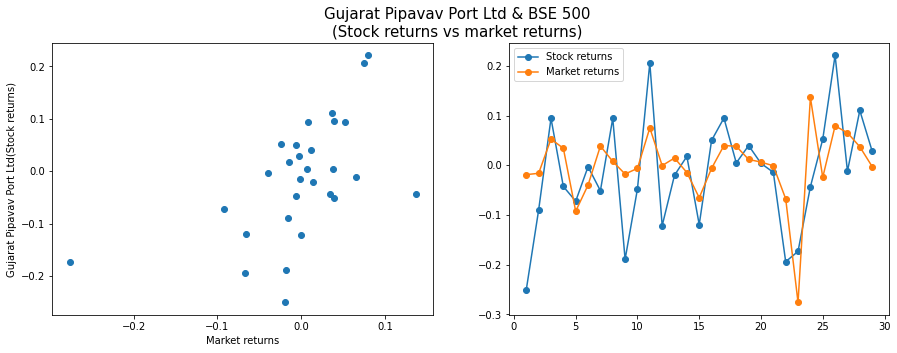

In [ ]:
returns_plot(gppl,'Gujarat Pipavav Port Ltd')

In [ ]:
results = ols_model(gppl)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     12.21
Date:                Thu, 29 Oct 2020   Prob (F-statistic):            0.00166
Time:                        17:08:04   Log-Likelihood:                 27.794
No. Observations:                  29   AIC:                            -51.59
Df Residuals:                      27   BIC:                            -48.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0224      0.025     -0.892      0.3

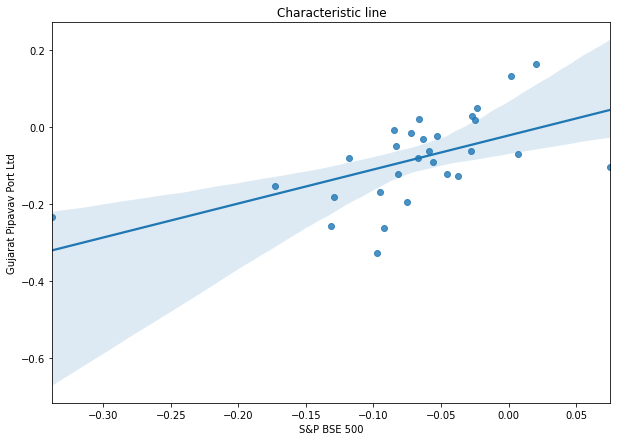

In [ ]:
characteristic_line(gppl,'Gujarat Pipavav Port Ltd')

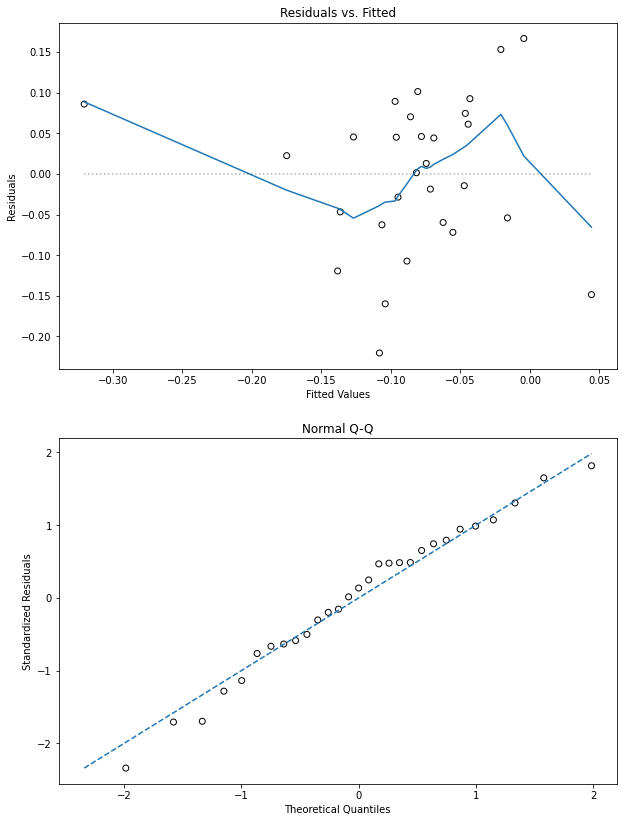

In [ ]:
diagnostic_plots(results)

#Century Plyboards India Ltd

In [ ]:
century_ply = create_df(df,'CENTURYPLY')

In [ ]:
century_ply.head()

,Date,BSE500,GOITenYR,CENTURYPLY,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,272.155212,-0.018921,-0.097221,-0.154278,-0.232578
2,01-06-2018,14528.54,0.0790,245.022476,-0.016191,-0.095191,-0.105023,-0.184023
3,01-07-2018,15314.81,0.0777,243.950806,0.052705,-0.024995,-0.004383,-0.082083
4,01-08-2018,15846.20,0.0795,217.597504,0.034109,-0.045391,-0.114320,-0.193820
5,01-09-2018,14445.89,0.0802,175.899841,-0.092520,-0.172720,-0.212732,-0.292932


In [ ]:
century_ply.describe()

,BSE500,GOITenYR,CENTURYPLY,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,166.268679,-0.000454,-0.069557,-0.023145,-0.092248
std,1057.421527,0.007230,39.792630,0.071257,0.071859,0.135418,0.137271
min,11098.230000,0.058400,101.699997,-0.276126,-0.337526,-0.323372,-0.384772
25%,14285.110000,0.063700,149.149994,-0.017713,-0.092513,-0.105023,-0.184023
50%,14627.620000,0.067000,163.816208,-0.000707,-0.066010,-0.004383,-0.082083
75%,15304.570000,0.075900,172.037201,0.038227,-0.028173,0.071445,0.005845
max,15846.200000,0.080200,272.155212,0.136469,0.075369,0.218892,0.145392


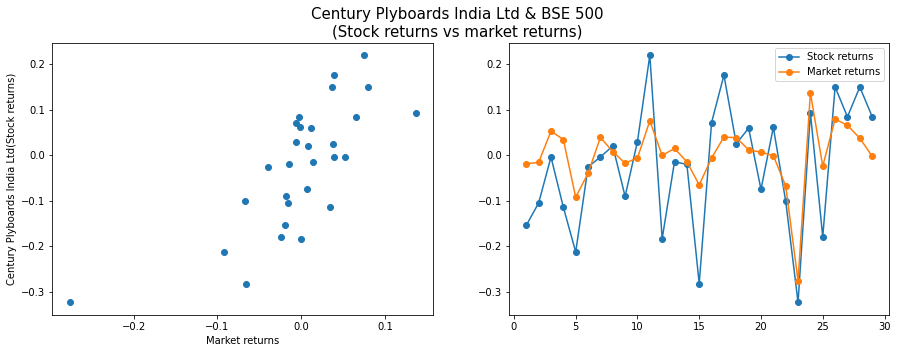

In [ ]:
returns_plot(century_ply,'Century Plyboards India Ltd')

In [ ]:
results = ols_model(century_ply)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     36.24
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           2.01e-06
Time:                        17:08:05   Log-Likelihood:                 29.289
No. Observations:                  29   AIC:                            -54.58
Df Residuals:                      27   BIC:                            -51.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.024      0.350      0.7

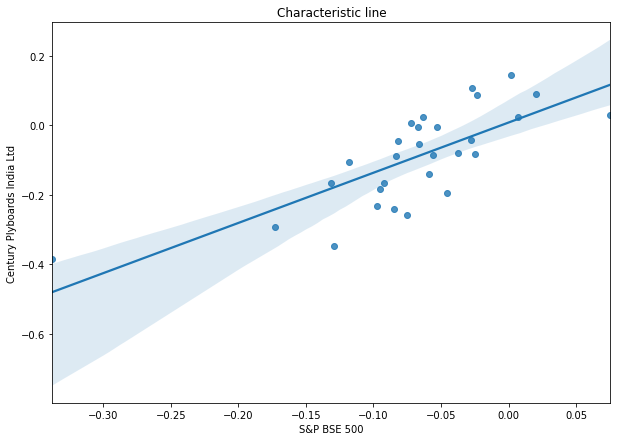

In [ ]:
characteristic_line(century_ply,'Century Plyboards India Ltd')

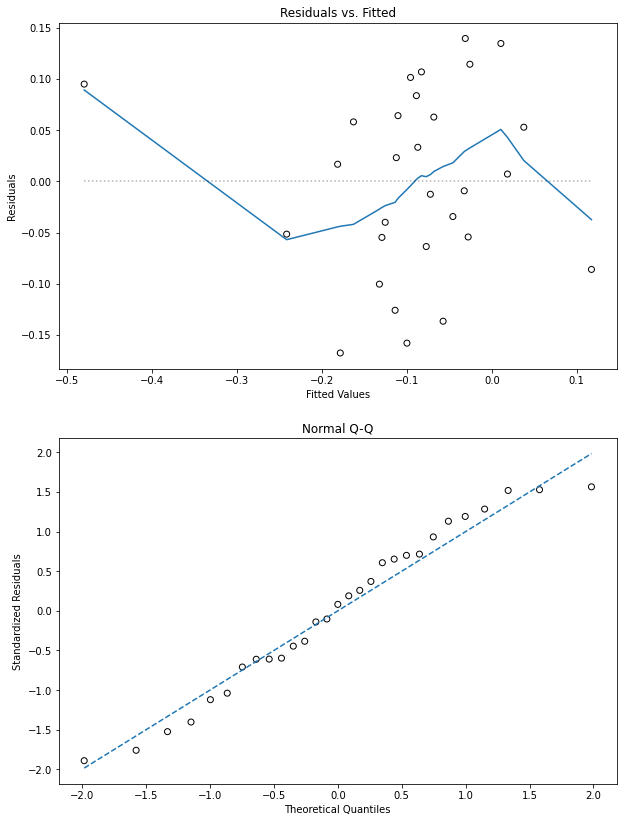

In [ ]:
diagnostic_plots(results)

#Tanla Solutions Ltd

In [ ]:
tanla = create_df(df,'TANLA')

In [ ]:
tanla.head()

,Date,BSE500,GOITenYR,TANLA,"r(m,t)",x(t),"r(i,t)",y(t)
1,01-05-2018,14765.69,0.0783,29.663439,-0.018921,-0.097221,-0.204247,-0.282547
2,01-06-2018,14528.54,0.0790,30.101814,-0.016191,-0.095191,0.014670,-0.064330
3,01-07-2018,15314.81,0.0777,39.064167,0.052705,-0.024995,0.260620,0.182920
4,01-08-2018,15846.20,0.0795,39.112881,0.034109,-0.045391,0.001246,-0.078254
5,01-09-2018,14445.89,0.0802,33.024323,-0.092520,-0.172720,-0.169207,-0.249407


In [ ]:
tanla.describe()

,BSE500,GOITenYR,TANLA,"r(m,t)",x(t),"r(i,t)",y(t)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14540.324138,0.069103,66.678490,-0.000454,-0.069557,0.071586,0.002483
std,1057.421527,0.007230,57.563980,0.071257,0.071859,0.236534,0.238573
min,11098.230000,0.058400,29.663439,-0.276126,-0.337526,-0.460672,-0.522072
25%,14285.110000,0.063700,36.624596,-0.017713,-0.092513,-0.059033,-0.134933
50%,14627.620000,0.067000,49.690670,-0.000707,-0.066010,0.020604,-0.044718
75%,15304.570000,0.075900,70.241234,0.038227,-0.028173,0.240335,0.177425
max,15846.200000,0.080200,290.081360,0.136469,0.075369,0.657326,0.596526


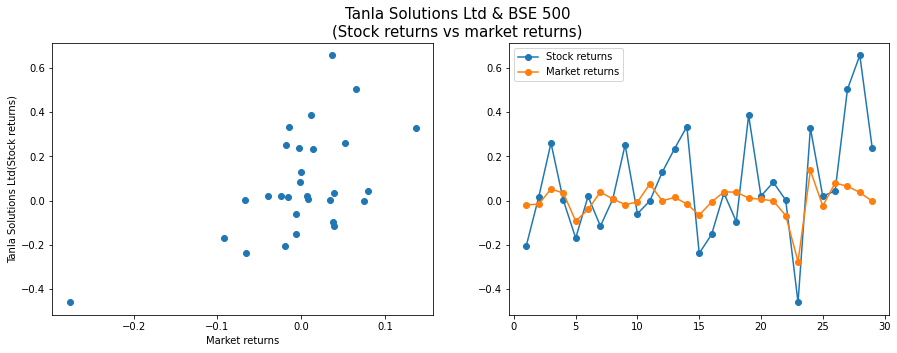

In [ ]:
returns_plot(tanla,'Tanla Solutions Ltd')

In [ ]:
results = ols_model(tanla)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   y(t)   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     15.20
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           0.000578
Time:                        17:08:07   Log-Likelihood:                 7.3956
No. Observations:                  29   AIC:                            -10.79
Df Residuals:                      27   BIC:                            -8.057
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1411      0.051      2.785      0.0

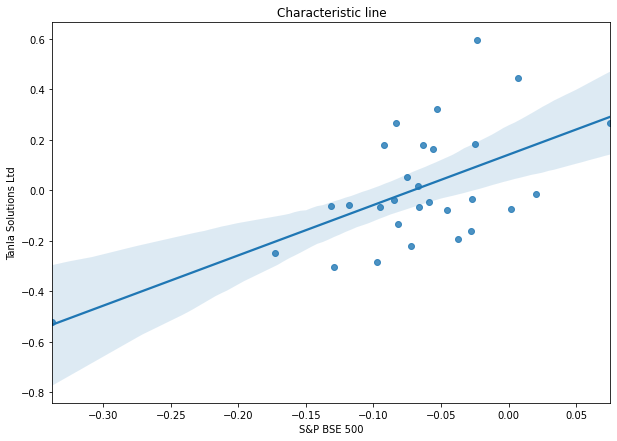

In [ ]:
characteristic_line(tanla,'Tanla Solutions Ltd')

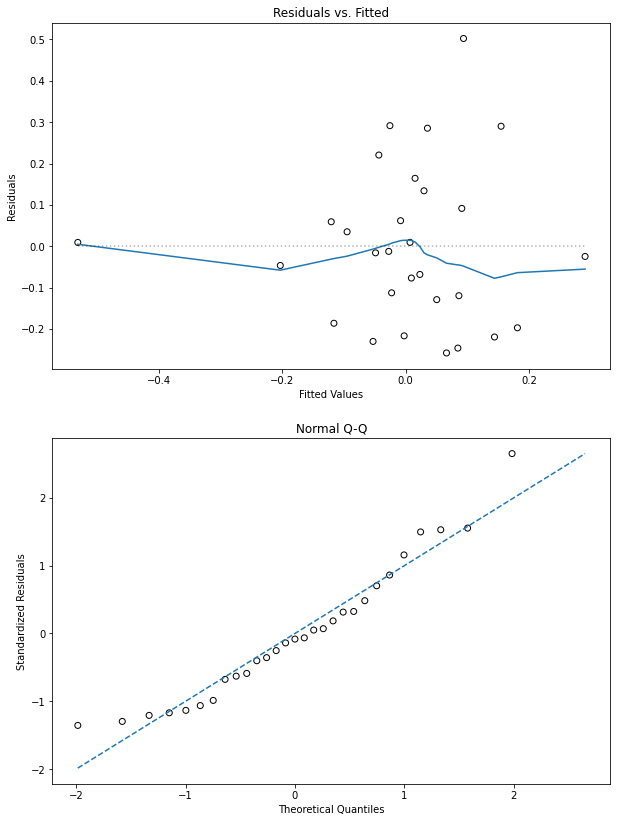

In [ ]:
diagnostic_plots(results)

In [ ]:
new_df = pd.concat([DhanBank[['r(m,t)','r(i,t)']],VIDHI['r(i,t)'],imfa['r(i,t)'],gppl['r(i,t)'],century_ply['r(i,t)'],tanla['r(i,t)']],1)

In [ ]:
new_df.columns = ['Market returns','Dhanlaxmi Bank Ltd','Vidhi Specialty Food Ingredients Ltd','Indian Metals & Ferro Alloys Ltd',
                  'Gujarat Pipavav Port Ltd','Century Plyboards India Ltd','Tanla Solutions Ltd']

In [ ]:
new_df.describe()

,Market returns,Dhanlaxmi Bank Ltd,Vidhi Specialty Food Ingredients Ltd,Indian Metals & Ferro Alloys Ltd,Gujarat Pipavav Port Ltd,Century Plyboards India Ltd,Tanla Solutions Ltd
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,-0.000454,-0.018935,0.008189,-0.023375,-0.014738,-0.023145,0.071586
std,0.071257,0.170812,0.154362,0.174204,0.111790,0.135418,0.236534
min,-0.276126,-0.498325,-0.347211,-0.617481,-0.250400,-0.323372,-0.460672
25%,-0.017713,-0.124053,-0.075134,-0.083382,-0.072330,-0.105023,-0.059033
50%,-0.000707,-0.029093,0.024865,0.013013,-0.011936,-0.004383,0.020604
75%,0.038227,0.061369,0.074108,0.073411,0.050000,0.071445,0.240335
max,0.136469,0.380018,0.360042,0.309023,0.221168,0.218892,0.657326


In [ ]:
skew_kurt = pd.concat([new_df.skew(),new_df.kurtosis()],1)

In [ ]:
skew_kurt.columns = ['Skewness','Kurtosis']

In [ ]:
skew_kurt

,Skewness,Kurtosis
Market returns,-1.927022,7.550978
Dhanlaxmi Bank Ltd,-0.258781,2.007143
Vidhi Specialty Food Ingredients Ltd,0.159274,0.954903
Indian Metals & Ferro Alloys Ltd,-1.384029,4.014130
Gujarat Pipavav Port Ltd,-0.019352,0.095995
Century Plyboards India Ltd,-0.386621,-0.316881
Tanla Solutions Ltd,0.369778,0.593472
